# Importing Necessary Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import re, string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, GRU, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Downloading necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Load and Explore Data

In [ ]:
# Load data
data = pd.read_json('/content/Sarcasm_Headlines_Dataset.json', lines=True)

In [ ]:
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [ ]:
data.shape

(28619, 3)

In [ ]:
data.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [ ]:
data.is_sarcastic.value_counts()

is_sarcastic
0    14985
1    13634
Name: count, dtype: int64

# Data Cleaning

In [ ]:
# Checking for duplicate values
data['headline'].duplicated().sum()

116

In [ ]:
# Drop duplicate headlines
data = data.drop(data[data['headline'].duplicated()].index, axis=0)

In [ ]:
# Rechecking for duplicate values
data['headline'].duplicated().sum()

0

In [ ]:
# Drop unnecessary columns
data = data.drop(columns=['article_link'])

In [ ]:
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


# Text Preprocessing

In [ ]:
# Define stopwords and punctuation to remove
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

# Define text preprocessing functions
def split_into_words(text):
    return text.split()

def to_lower_case(words):
    return [word.lower() for word in words]

def remove_punctuation(words):
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    return [re_punc.sub('', w) for w in words]

def keep_alphabetic(words):
    return [word for word in words if word.isalpha()]

def remove_stopwords(words):
    return [w for w in words if not w in stop]

def to_sentence(words):
    return ' '.join(words)

def denoise_text(text):
    words = split_into_words(text)
    words = to_lower_case(words)
    words = remove_punctuation(words)
    words = keep_alphabetic(words)
    words = remove_stopwords(words)
    return to_sentence(words)

# Apply text cleaning to the 'headline' column
data['news_headline'] = data['headline'].apply(denoise_text)

In [ ]:
# Display the first few rows after text cleaning
data.head()

,is_sarcastic,headline,news_headline
0,1,thirtysomething scientists unveil doomsday clo...,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,dem rep totally nails congress falling short g...
2,0,eat your veggies: 9 deliciously different recipes,eat veggies deliciously different recipes
3,1,inclement weather prevents liar from getting t...,inclement weather prevents liar getting work
4,1,mother comes pretty close to using word 'strea...,mother comes pretty close using word streaming...


# Splitting Data into Training and Testing Sets

In [ ]:
# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    data['news_headline'], data['is_sarcastic'], test_size=0.20, random_state=42
)

# Label encoding the target variable
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Display the first few rows of training data and labels
print(train_data.head())
print(train_labels_encoded[:5])

2827     new law requires welfare recipients submit swe...
24271    jake tappers grim reminder steve bannon isnt p...
20969             journalists refuse take nonanswer answer
5678                    report shit last night trash night
5267                           importance first responders
Name: news_headline, dtype: object
[1 0 0 1 0]


# Tokenization and Padding

In [ ]:
# Tokenization: converting text to sequences of integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data)   #updates internal vocabulary based on a list of texts
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size:", vocab_size)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

# Padding sequences to ensure uniform length
max_length = max([len(x) for x in train_sequences])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Display the shape of the padded sequences
print(train_padded.shape)
print(test_padded.shape)

Vocabulary Size: 25734
(22802, 106)
(5701, 106)


# Building, Training and Evaluating the CNN-LSTM Model

In [ ]:
# Building the CNN-LSTM model
embedding_dim = 200  # Increased embedding dimension

cnn_lstm_model = Sequential()
cnn_lstm_model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

# Adjusted convolutional layer parameters
cnn_lstm_model.add(Conv1D(1024, 12, activation='relu'))
cnn_lstm_model.add(MaxPooling1D(pool_size=4))
cnn_lstm_model.add(Dropout(0.3))

# Bidirectional LSTM layer with increased units
cnn_lstm_model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)))
cnn_lstm_model.add(Dense(64, activation='relu'))
cnn_lstm_model.add(Dropout(0.3))

cnn_lstm_model.add(Dense(1, activation='sigmoid'))

# Compiling the model with a lower learning rate
cnn_lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
print(cnn_lstm_model.summary())

# Adding EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model
history_cnn_lstm = cnn_lstm_model.fit(
    train_padded, train_labels_encoded,
    epochs=5, batch_size=64, validation_data=(test_padded, test_labels_encoded),
    callbacks=[ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0), early_stopping]
)

# Evaluate the model
cnn_lstm_raw_predictions = cnn_lstm_model.predict(test_padded)
cnn_lstm_predictions = np.where(cnn_lstm_raw_predictions > 0.5, 1, 0)

print("CNN-LSTM Model Accuracy:", accuracy_score(test_labels_encoded, cnn_lstm_predictions))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 106, 200)          5146800   
                                                                 
 conv1d (Conv1D)             (None, 95, 1024)          2458624   
                                                                 
 max_pooling1d (MaxPooling1  (None, 23, 1024)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 1024)          0         
                                                                 
 bidirectional (Bidirection  (None, 256)               1180672   
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                1

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded, cnn_lstm_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
print("Classification Report:")
print(classification_report(test_labels_encoded, cnn_lstm_predictions))

Confusion Matrix:
[[2506  542]
 [ 533 2120]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      3048
           1       0.80      0.80      0.80      2653

    accuracy                           0.81      5701
   macro avg       0.81      0.81      0.81      5701
weighted avg       0.81      0.81      0.81      5701



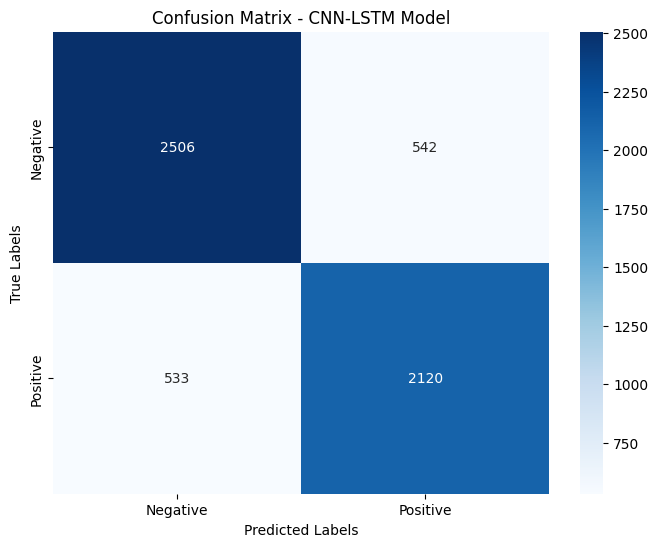

In [ ]:
# Plot heatmap for confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - CNN-LSTM Model')
plt.show()

# Making Predictions on New Data

In [ ]:
# Function to preprocess, tokenize, and pad a new sentence
def preprocess_and_predict(sentence, tokenizer, model, max_length):
    def preprocess_text(text):
        # Denoise text using the same preprocessing steps
        stop = set(stopwords.words('english'))
        punctuation = list(string.punctuation)
        stop.update(punctuation)

        def split_into_words(text):
            return text.split()

        def to_lower_case(words):
            return [word.lower() for word in words]

        def remove_punctuation(words):
            re_punc = re.compile('[%s]' % re.escape(string.punctuation))
            return [re_punc.sub('', w) for w in words]

        def keep_alphabetic(words):
            return [word for word in words if word.isalpha()]

        def remove_stopwords(words):
            return [w for w in words if not w in stop]

        def to_sentence(words):
            return ' '.join(words)

        words = split_into_words(text)
        words = to_lower_case(words)
        words = remove_punctuation(words)
        words = keep_alphabetic(words)
        words = remove_stopwords(words)
        return to_sentence(words)

    # Preprocess the input sentence
    processed_sentence = preprocess_text(sentence)

    # Tokenize and pad the input sentence
    sequence = tokenizer.texts_to_sequences([processed_sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')

    # Make prediction
    prediction = model.predict(padded_sequence)
    return "Sarcastic" if prediction > 0.5 else "Not Sarcastic"

In [ ]:
# Example usage
new_sentence = "My name is Priyanshu."
result = preprocess_and_predict(new_sentence, tokenizer, cnn_lstm_model, max_length)
print(f'The sentence "{new_sentence}" is {result}.')

1/1 [==============================] - 0s 126ms/step
The sentence "My name is Priyanshu." is Not Sarcastic.


In [ ]:
# Example usage
new_sentence = "I am busy right now, can I ignore you some other time?"
result = preprocess_and_predict(new_sentence, tokenizer, cnn_lstm_model, max_length)
print(f'The sentence "{new_sentence}" is {result}.')

1/1 [==============================] - 0s 30ms/step
The sentence "I am busy right now, can I ignore you some other time?" is Sarcastic.


In [ ]:
# Example usage
new_sentence = "I love watching cricket"
result = preprocess_and_predict(new_sentence, tokenizer, cnn_lstm_model, max_length)
print(f'The sentence "{new_sentence}" is {result}.')

1/1 [==============================] - 0s 28ms/step
The sentence "I love watching cricket" is Not Sarcastic.


In [ ]:
# Example usage
new_sentence = "I’m so thrilled to be working overtime on the weekend."
result = preprocess_and_predict(new_sentence, tokenizer, cnn_lstm_model, max_length)
print(f'The sentence "{new_sentence}" is {result}.')

1/1 [==============================] - 0s 51ms/step
The sentence "I’m so thrilled to be working overtime on the weekend." is Sarcastic.


In [ ]:
# Example usage
new_sentence = "thirtysomething scientists unveil doomsday clock of hair loss"
result = preprocess_and_predict(new_sentence, tokenizer, cnn_lstm_model, max_length)
print(f'The sentence "{new_sentence}" is {result}.')

1/1 [==============================] - 0s 45ms/step
The sentence "thirtysomething scientists unveil doomsday clock of hair loss" is Sarcastic.


In [ ]:
# Example usage
new_sentence = "this new orange era: the growing divide"
result = preprocess_and_predict(new_sentence, tokenizer, cnn_lstm_model, max_length)
print(f'The sentence "{new_sentence}" is {result}.')

1/1 [==============================] - 0s 47ms/step
The sentence "this new orange era: the growing divide" is Not Sarcastic.
